In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
%matplotlib inline

from pandas.tseries.offsets import BDay
from pandas.tseries.holiday import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib
from scipy.stats import pearsonr

# Data cleanup & feature manipulation

In [2]:
# Import data
acc = pd.read_csv('acc2005_2016.csv')
veh = pd.read_csv('veh2005_2016.csv')

# Replace all -1 missing values to NA
acc.replace(-1, np.nan, inplace=True)
veh.replace(-1, np.nan, inplace=True)

D:\Anaconda3\envs\FYP_TAP_ENV\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Inspect Accident dataset
acc.columns

Index(['Accident_Index', 'Location_Easting_OSGR', 'Location_Northing_OSGR',
       'Longitude', 'Latitude', 'Police_Force', 'Accident_Severity',
       'Number_of_Vehicles', 'Number_of_Casualties', 'Date', 'Day_of_Week',
       'Time', 'Local_Authority_.District.', 'Local_Authority_.Highway.',
       'X1st_Road_Class', 'X1st_Road_Number', 'Road_Type', 'Speed_limit',
       'Junction_Detail', 'Junction_Control', 'X2nd_Road_Class',
       'X2nd_Road_Number', 'Pedestrian_Crossing.Human_Control',
       'Pedestrian_Crossing.Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident',
       'LSOA_of_Accident_Location'],
      dtype='object')

In [4]:
# Tidy up columns names
acc.rename(lambda x: x.replace('.', ''), axis=1, inplace=True) # Inplace to ensure it changes the variable itself
acc.columns # Inspect the resulting column names

Index(['Accident_Index', 'Location_Easting_OSGR', 'Location_Northing_OSGR',
       'Longitude', 'Latitude', 'Police_Force', 'Accident_Severity',
       'Number_of_Vehicles', 'Number_of_Casualties', 'Date', 'Day_of_Week',
       'Time', 'Local_Authority_District', 'Local_Authority_Highway',
       'X1st_Road_Class', 'X1st_Road_Number', 'Road_Type', 'Speed_limit',
       'Junction_Detail', 'Junction_Control', 'X2nd_Road_Class',
       'X2nd_Road_Number', 'Pedestrian_CrossingHuman_Control',
       'Pedestrian_CrossingPhysical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident',
       'LSOA_of_Accident_Location'],
      dtype='object')

In [5]:
# Tidy up column names again to standardise
acc.rename(columns={
    'Speed_limit': 'Speed_Limit',
    'Pedestrian_CrossingHuman_Control': 'Pedestrian_Crossing_Human_Control',
    'Pedestrian_CrossingPhysical_Facilities': 'Pedestrian_Crossing_Physical_Facilities'
}, inplace=True)
acc.columns # Inspect once more to ensure its standardise

Index(['Accident_Index', 'Location_Easting_OSGR', 'Location_Northing_OSGR',
       'Longitude', 'Latitude', 'Police_Force', 'Accident_Severity',
       'Number_of_Vehicles', 'Number_of_Casualties', 'Date', 'Day_of_Week',
       'Time', 'Local_Authority_District', 'Local_Authority_Highway',
       'X1st_Road_Class', 'X1st_Road_Number', 'Road_Type', 'Speed_Limit',
       'Junction_Detail', 'Junction_Control', 'X2nd_Road_Class',
       'X2nd_Road_Number', 'Pedestrian_Crossing_Human_Control',
       'Pedestrian_Crossing_Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident',
       'LSOA_of_Accident_Location'],
      dtype='object')

In [6]:
# Check columns and remove records that have MNAR values
acc.isnull().any()

Accident_Index                                 False
Location_Easting_OSGR                           True
Location_Northing_OSGR                          True
Longitude                                       True
Latitude                                        True
Police_Force                                   False
Accident_Severity                              False
Number_of_Vehicles                             False
Number_of_Casualties                           False
Date                                           False
Day_of_Week                                    False
Time                                            True
Local_Authority_District                       False
Local_Authority_Highway                        False
X1st_Road_Class                                False
X1st_Road_Number                                True
Road_Type                                       True
Speed_Limit                                     True
Junction_Detail                               

In [7]:
# Date Time cannot be imputed since there is no way to "guess" the date an accident occur, remove associated records
acc.dropna(subset=['Time', 'Speed_Limit'], inplace=True)

# We know that if the accident record doesn't exist, the vehicle record cannot exist. Therefore, remove vehicle records 
# that no longer have an associating accident
veh.drop(veh.index[veh.set_index('Accident_Index').index.isin(acc.set_index('Accident_Index').index) ^ True], 
         axis=0, inplace=True)

In [8]:
# Repeat for Vehicle dataset
veh.columns

Index(['Accident_Index', 'Vehicle_Reference', 'Vehicle_Type',
       'Towing_and_Articulation', 'Vehicle_Manoeuvre',
       'Vehicle_Location.Restricted_Lane', 'Junction_Location',
       'Skidding_and_Overturning', 'Hit_Object_in_Carriageway',
       'Vehicle_Leaving_Carriageway', 'Hit_Object_off_Carriageway',
       'X1st_Point_of_Impact', 'Was_Vehicle_Left_Hand_Drive.',
       'Journey_Purpose_of_Driver', 'Sex_of_Driver', 'Age_of_Driver',
       'Age_Band_of_Driver', 'Engine_Capacity_.CC.', 'Propulsion_Code',
       'Age_of_Vehicle', 'Driver_IMD_Decile', 'Driver_Home_Area_Type',
       'Vehicle_IMD_Decile'],
      dtype='object')

In [9]:
veh.rename(lambda x: x.replace('.', ''), axis=1, inplace=True)
veh.columns

Index(['Accident_Index', 'Vehicle_Reference', 'Vehicle_Type',
       'Towing_and_Articulation', 'Vehicle_Manoeuvre',
       'Vehicle_LocationRestricted_Lane', 'Junction_Location',
       'Skidding_and_Overturning', 'Hit_Object_in_Carriageway',
       'Vehicle_Leaving_Carriageway', 'Hit_Object_off_Carriageway',
       'X1st_Point_of_Impact', 'Was_Vehicle_Left_Hand_Drive',
       'Journey_Purpose_of_Driver', 'Sex_of_Driver', 'Age_of_Driver',
       'Age_Band_of_Driver', 'Engine_Capacity_CC', 'Propulsion_Code',
       'Age_of_Vehicle', 'Driver_IMD_Decile', 'Driver_Home_Area_Type',
       'Vehicle_IMD_Decile'],
      dtype='object')

In [10]:
veh.rename(columns={
    'Vehicle_LocationRestricted_Lane': 'Vehicle_Location_Restricted_Lane'
}, inplace=True)
veh.columns

Index(['Accident_Index', 'Vehicle_Reference', 'Vehicle_Type',
       'Towing_and_Articulation', 'Vehicle_Manoeuvre',
       'Vehicle_Location_Restricted_Lane', 'Junction_Location',
       'Skidding_and_Overturning', 'Hit_Object_in_Carriageway',
       'Vehicle_Leaving_Carriageway', 'Hit_Object_off_Carriageway',
       'X1st_Point_of_Impact', 'Was_Vehicle_Left_Hand_Drive',
       'Journey_Purpose_of_Driver', 'Sex_of_Driver', 'Age_of_Driver',
       'Age_Band_of_Driver', 'Engine_Capacity_CC', 'Propulsion_Code',
       'Age_of_Vehicle', 'Driver_IMD_Decile', 'Driver_Home_Area_Type',
       'Vehicle_IMD_Decile'],
      dtype='object')

In [11]:
# Check if any Vehicle features are MNAR
veh.isnull().any()

Accident_Index                      False
Vehicle_Reference                   False
Vehicle_Type                         True
Towing_and_Articulation              True
Vehicle_Manoeuvre                    True
Vehicle_Location_Restricted_Lane     True
Junction_Location                    True
Skidding_and_Overturning             True
Hit_Object_in_Carriageway            True
Vehicle_Leaving_Carriageway          True
Hit_Object_off_Carriageway           True
X1st_Point_of_Impact                 True
Was_Vehicle_Left_Hand_Drive          True
Journey_Purpose_of_Driver            True
Sex_of_Driver                        True
Age_of_Driver                        True
Age_Band_of_Driver                   True
Engine_Capacity_CC                   True
Propulsion_Code                      True
Age_of_Vehicle                       True
Driver_IMD_Decile                    True
Driver_Home_Area_Type                True
Vehicle_IMD_Decile                   True
dtype: bool

In [12]:
# Was_Vehicle_Left_Hand_Drive feature cannot be imputed as it is part of the aim factor of the project
veh_ind = list(set(veh.loc[veh['Was_Vehicle_Left_Hand_Drive'].isnull(), 'Accident_Index']))

# Remove every record that has the feature with missing value alongside vehicles incolved with the same Accident_Index
veh.drop(veh.index[veh.set_index('Accident_Index').index.isin(veh_ind) ^ False], axis=0, inplace=True)

# Remove every Accidents which is associated with the removed Vehicles
acc.drop(acc.index[acc.set_index('Accident_Index').index.isin(veh.set_index('Accident_Index').index) ^ True], 
         axis=0, inplace=True)

In [13]:
# Remove noisy features
acc.drop([
    'Location_Easting_OSGR', 'Location_Northing_OSGR', 'LSOA_of_Accident_Location', 'Longitude', 'Latitude', 
    'Local_Authority_District', 'Local_Authority_Highway', # Not interested in locational data
    'Police_Force', 'Did_Police_Officer_Attend_Scene_of_Accident', # Police involvement unrelated
    'Number_of_Vehicles', 'Number_of_Casualties', # After accident occur data irrelevant
    'X1st_Road_Number', 'X2nd_Road_Number' # Locational road data
], axis=1, inplace=True)
veh.drop([
    'Vehicle_Reference', # Reference value not useful
    'Towing_and_Articulation', # After accident occur data irrelevant
    'Age_of_Driver' # Age_Band_of_Driver more general
], axis=1, inplace=True)

In [14]:
# Combine Date and Time to utilise datetime utility from Pandas
acc['Date_Time'] = pd.to_datetime(acc['Date'] + ' ' + acc['Time'], format='%d/%m/%Y %H:%M')
acc.drop(['Date', 'Time'], axis=1, inplace=True)

In [15]:
# Create a new feature is_holiday to indicate if the accident occured on a holiday

# Create calender of GB Bank Holidays
class UKBankHolidays(AbstractHolidayCalendar):
    rules = [
        Holiday('New Years Day', month=1, day=1, observance=sunday_to_monday),
        GoodFriday,
        EasterMonday,
        Holiday('Early May Bank', month=5, day=1, observance=DateOffset(weekday=MO(1))),
        Holiday('Spring Bank', month=5, day=25, observance=DateOffset(weekday=MO(1))),
        Holiday('Summer Bank', month=8, day=25, observance=DateOffset(weekday=MO(1))),
        Holiday('Christmas Day', month=12, day=25, observance=sunday_to_monday),
        Holiday('Boxing Day', month=12, day=26, observance=next_monday_or_tuesday)
    ]

# Create the feature
ukhols = UKBankHolidays().holidays(min(acc['Date_Time']), max(acc['Date_Time']))
acc['Is_Holiday'] = 0
acc.loc[acc['Date_Time'].dt.date.apply(lambda x: x in ukhols), ('Is_Holiday')] = 1

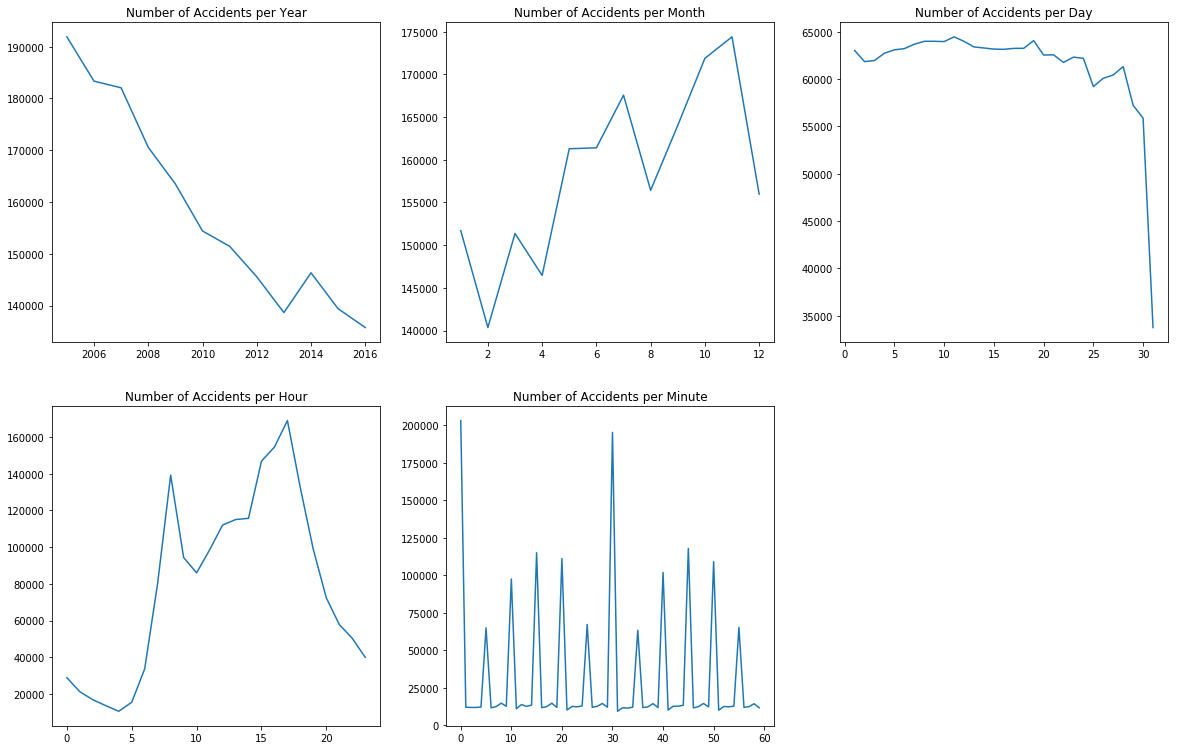

In [16]:
# Analyse DateTime and determine the split to Year, Month, Day, Hour and Minute 
# to determine if the split shows interesting patterns
fig = plt.figure(figsize=[20,20])
nrow, ncol, ind = 3, 3, 1

# Year
ax = fig.add_subplot(nrow, ncol, ind)
ax.plot(*zip(*[
    (yr, cnt)
    for yr, cnt in zip(range(min(acc['Date_Time'].dt.year), max(acc['Date_Time'].dt.year) + 1), 
                       acc['Accident_Severity'].groupby(acc['Date_Time'].dt.year).count().tolist())
]))
ax.set_title('Number of Accidents per Year')
ind += 1

# Month
ax = fig.add_subplot(nrow, ncol, ind)
ax.plot(*zip(*[
    (yr, cnt)
    for yr, cnt in zip(range(min(acc['Date_Time'].dt.month), max(acc['Date_Time'].dt.month) + 1), 
                       acc['Accident_Severity'].groupby(acc['Date_Time'].dt.month).count().tolist())
]))
ax.set_title('Number of Accidents per Month')
ind += 1

# Day
ax = fig.add_subplot(nrow, ncol, ind)
ax.plot(*zip(*[
    (yr, cnt)
    for yr, cnt in zip(range(min(acc['Date_Time'].dt.day), max(acc['Date_Time'].dt.day) + 1), 
                       acc['Accident_Severity'].groupby(acc['Date_Time'].dt.day).count().tolist())
]))
ax.set_title('Number of Accidents per Day')
ind += 1

# Hour
ax = fig.add_subplot(nrow, ncol, ind)
ax.plot(*zip(*[
    (yr, cnt)
    for yr, cnt in zip(range(min(acc['Date_Time'].dt.hour), max(acc['Date_Time'].dt.hour) + 1), 
                       acc['Accident_Severity'].groupby(acc['Date_Time'].dt.hour).count().tolist())
]))
ax.set_title('Number of Accidents per Hour')
ind += 1

# Minute
ax = fig.add_subplot(nrow, ncol, ind)
ax.plot(*zip(*[
    (yr, cnt)
    for yr, cnt in zip(range(min(acc['Date_Time'].dt.minute), max(acc['Date_Time'].dt.minute) + 1), 
                       acc['Accident_Severity'].groupby(acc['Date_Time'].dt.minute).count().tolist())
]))
ax.set_title('Number of Accidents per Minute')
ind += 1

plt.show()

In [17]:
# Only Minute has no useful pattern as its an interval of 5 minutes.
# Day is already included as acc.Day_of_Week
acc['Year'], acc['Month'], acc['Hour'] = acc['Date_Time'].dt.year, acc['Date_Time'].dt.month, acc['Date_Time'].dt.hour

# Missing data analysis Stage 1

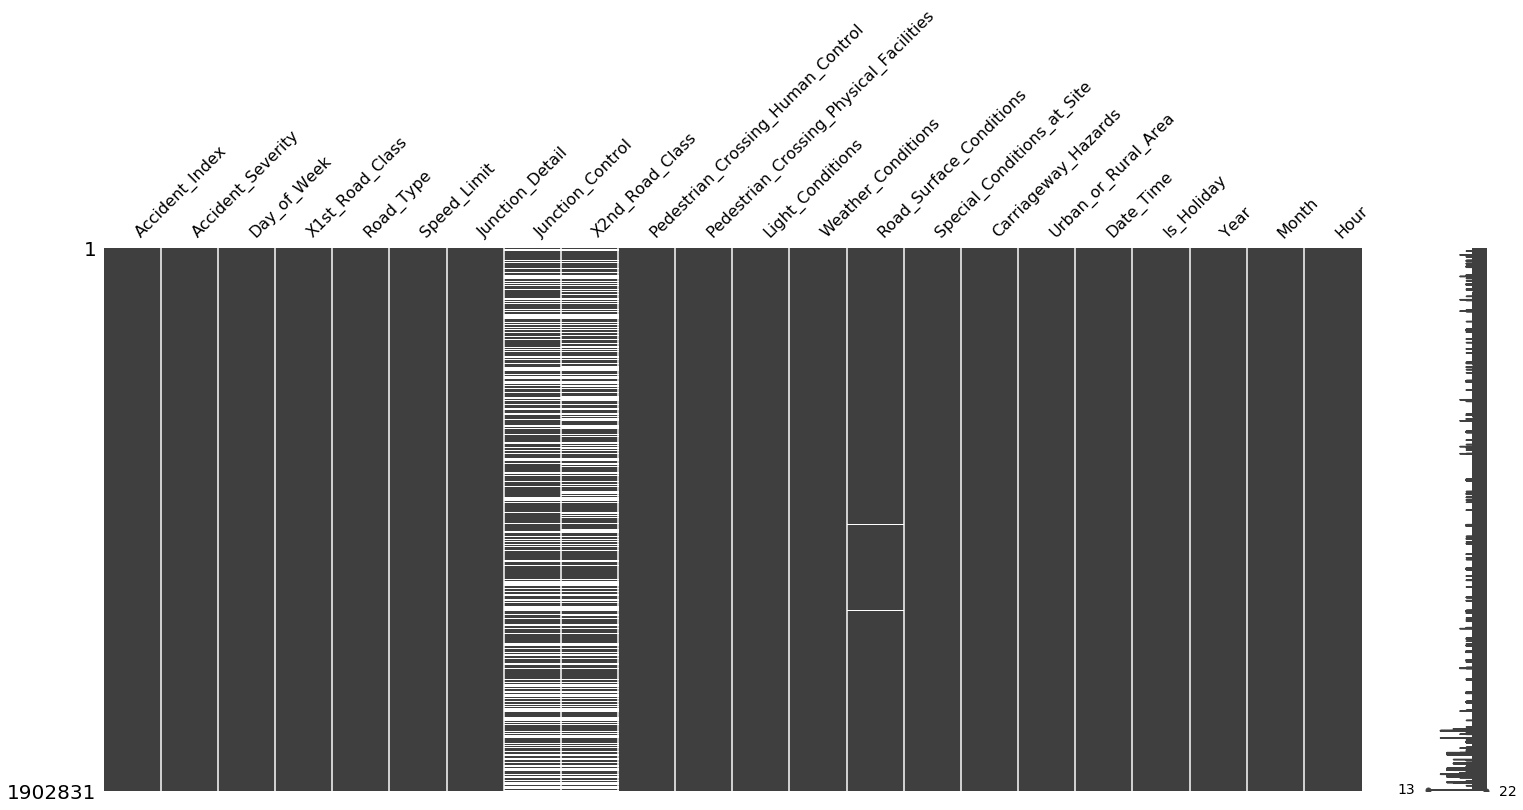

In [18]:
# Analyse missing value patterns for Accidents
msno.matrix(acc)

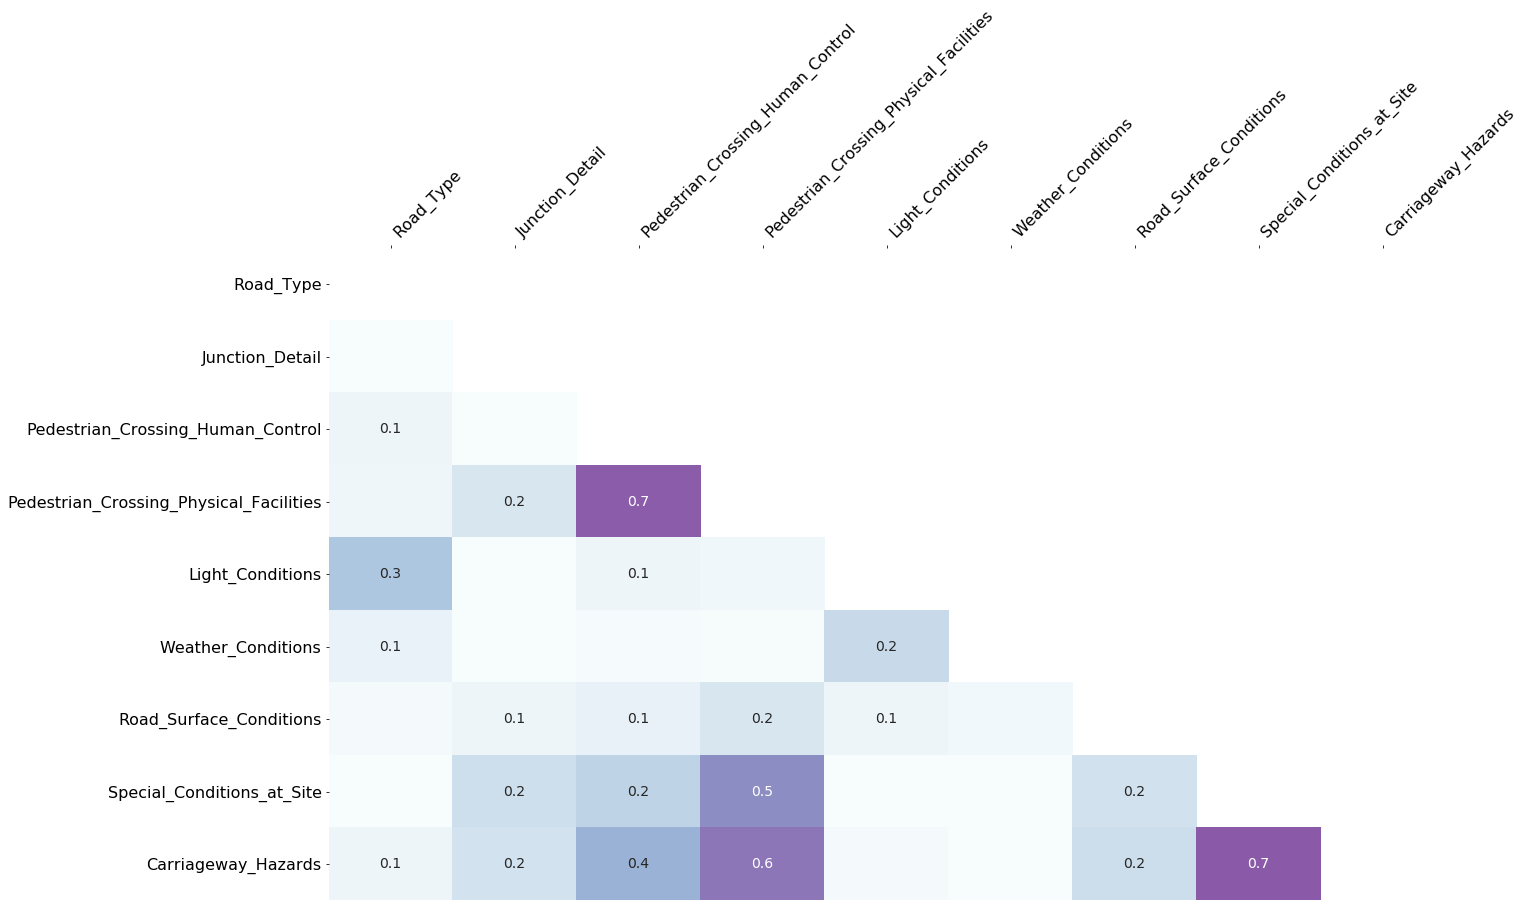

In [42]:
msno.heatmap(acc, cmap='BuPu')

In [19]:
# Junction_Detail and X2nd_Road_Class has pretty dramatic missing values, look into it more deeply
[(col, x, round((x/len(acc)) * 100, 2)) for col, x in zip(acc.columns, acc.isnull().sum(axis=0).tolist()) if x > 0]

[('Road_Type', 1, 0.0),
 ('Junction_Detail', 49, 0.0),
 ('Junction_Control', 694815, 36.51),
 ('X2nd_Road_Class', 783378, 41.17),
 ('Pedestrian_Crossing_Human_Control', 329, 0.02),
 ('Pedestrian_Crossing_Physical_Facilities', 499, 0.03),
 ('Light_Conditions', 10, 0.0),
 ('Weather_Conditions', 171, 0.01),
 ('Road_Surface_Conditions', 2921, 0.15),
 ('Special_Conditions_at_Site', 304, 0.02),
 ('Carriageway_Hazards', 382, 0.02)]

In [20]:
# Junction_Detail and X2nd_Road_Class has > 10% missing values, remove them
# The rest will be imputed with R Mice
acc.drop(['Junction_Control', 'X2nd_Road_Class'], axis=1, inplace=True)

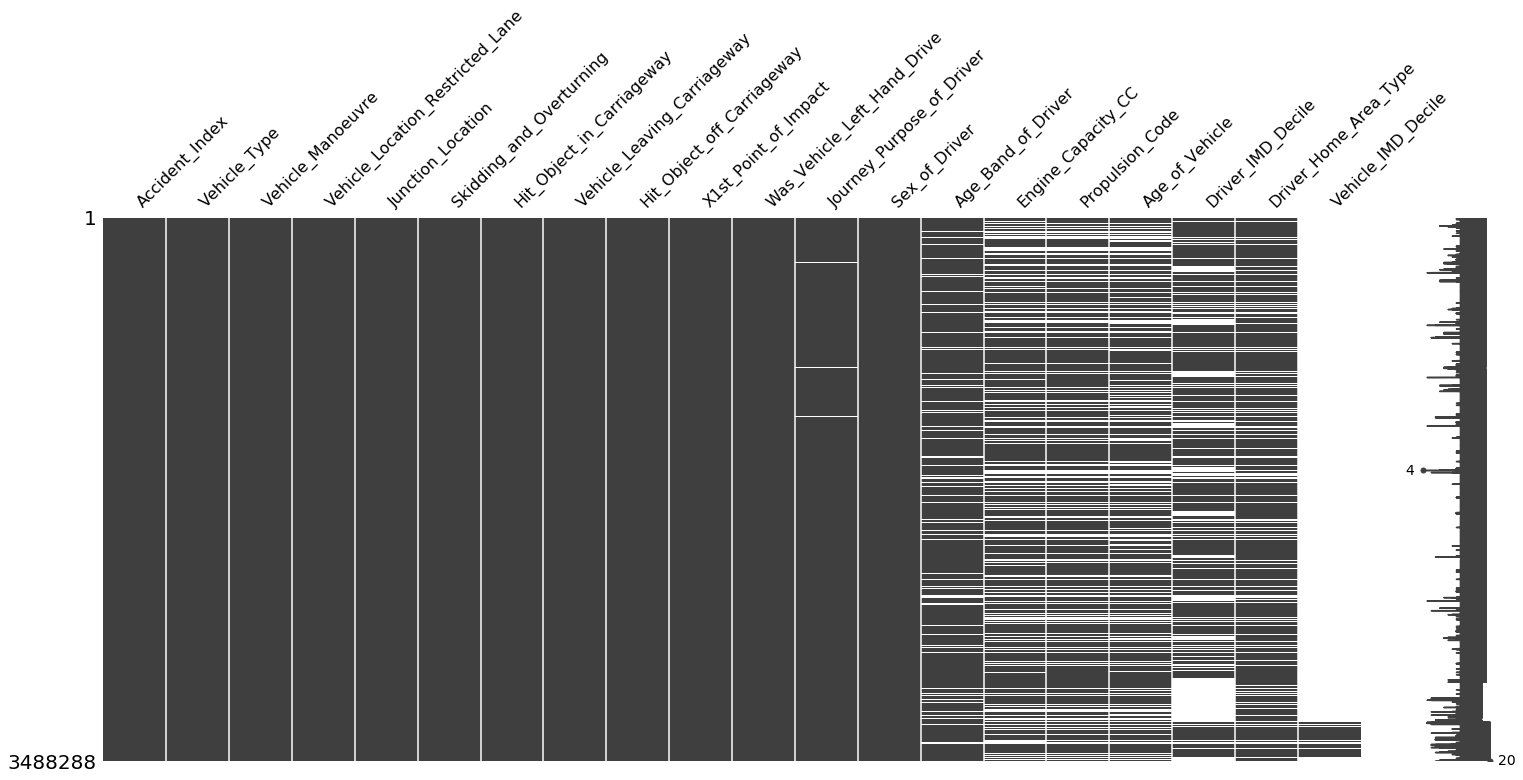

In [21]:
msno.matrix(veh)

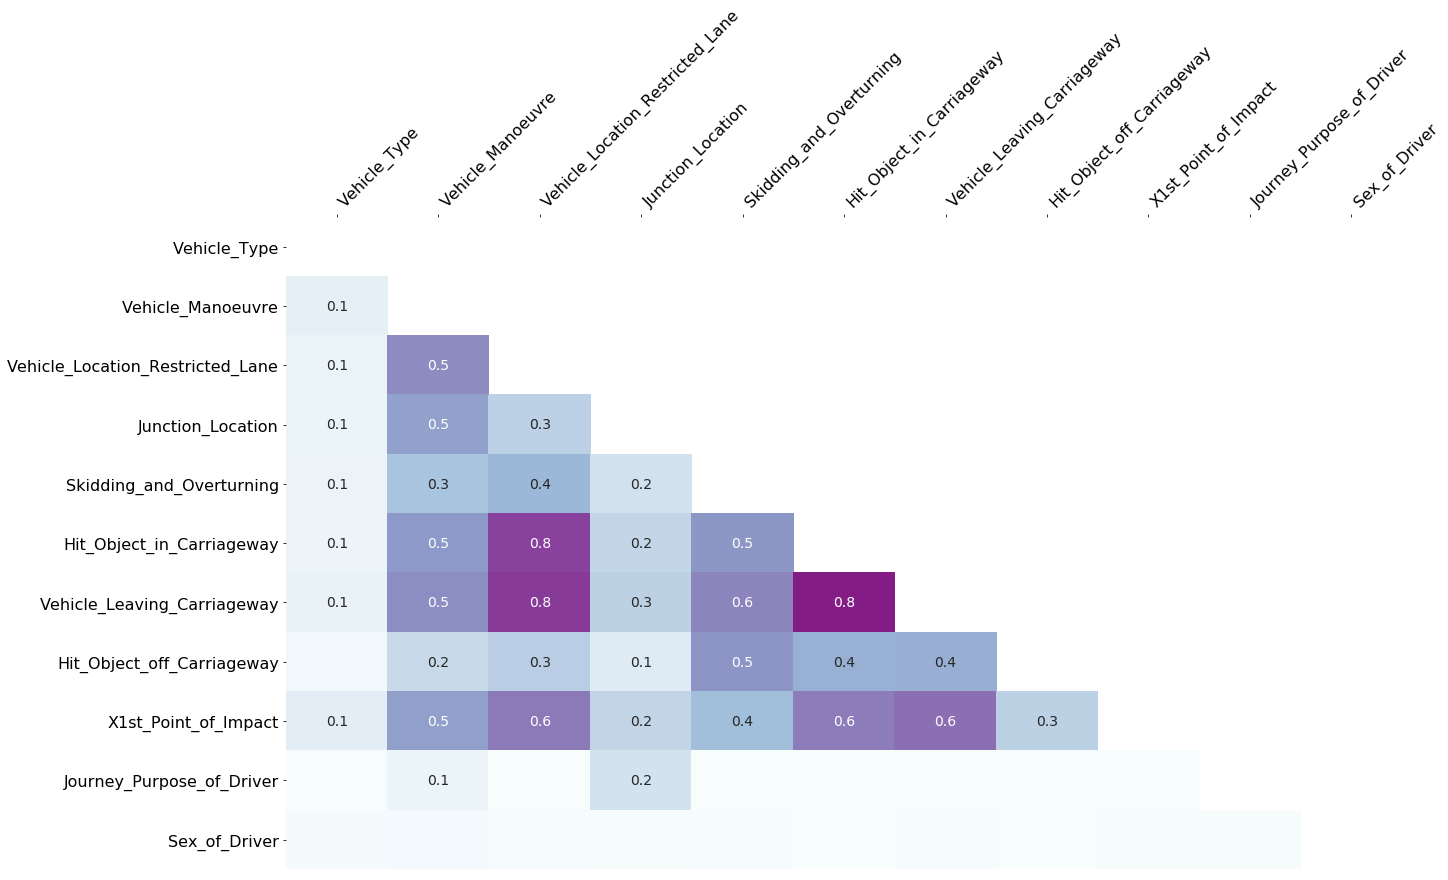

In [44]:
msno.heatmap(veh, cmap='BuPu')

In [22]:
[(col, x, round((x/len(veh)) * 100, 2)) for col, x in zip(veh.columns, veh.isnull().sum(axis=0).tolist()) if x > 0]

[('Vehicle_Type', 833, 0.02),
 ('Vehicle_Manoeuvre', 1402, 0.04),
 ('Vehicle_Location_Restricted_Lane', 849, 0.02),
 ('Junction_Location', 1694, 0.05),
 ('Skidding_and_Overturning', 485, 0.01),
 ('Hit_Object_in_Carriageway', 847, 0.02),
 ('Vehicle_Leaving_Carriageway', 867, 0.02),
 ('Hit_Object_off_Carriageway', 201, 0.01),
 ('X1st_Point_of_Impact', 1540, 0.04),
 ('Journey_Purpose_of_Driver', 22621, 0.65),
 ('Sex_of_Driver', 89, 0.0),
 ('Age_Band_of_Driver', 387084, 11.1),
 ('Engine_Capacity_CC', 910548, 26.1),
 ('Propulsion_Code', 891226, 25.55),
 ('Age_of_Vehicle', 1015462, 29.11),
 ('Driver_IMD_Decile', 1167488, 33.47),
 ('Driver_Home_Area_Type', 676919, 19.41),
 ('Vehicle_IMD_Decile', 3304003, 94.72)]

In [23]:
veh.drop(['Age_Band_of_Driver', 'Engine_Capacity_CC', 'Propulsion_Code', 'Age_of_Vehicle', 'Driver_IMD_Decile',
         'Driver_Home_Area_Type', 'Vehicle_IMD_Decile'], axis=1, inplace=True)

# Feature Selection Stage 1
## Use backward elimination by recursively fitting LDA
 - 5 different solvers are used:
  - Single value decomposition
  - Least Square
  - Eigen
  - Least Square with shrinkage
  - Eigen with shrinkage
 - The best features are selected by fitting the resulting feature set with a Random Forest of 30 trees

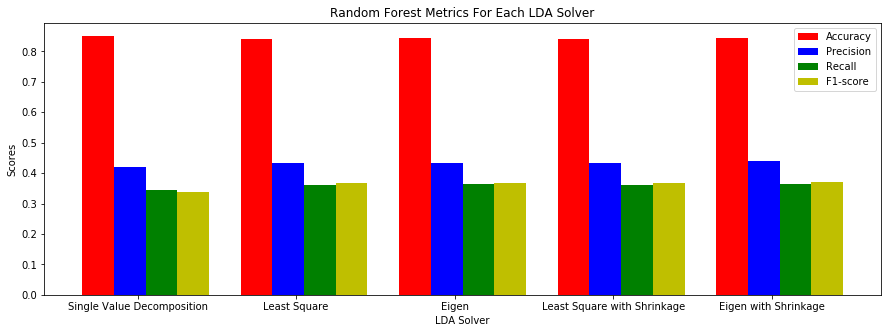

In [24]:
fs_res = joblib.load('lda-rfe-fs1-res.pkl')
N = len(fs_res)
ind = np.arange(N)
width = 0.2

fig, ax = plt.subplots(figsize=[15,5])

rects = [
    ax.bar(ind - width, [fs['ACC'] for _, fs in fs_res.items()], width=width, color='r'),
    ax.bar(ind, [fs['PRF1'][0] for _, fs in fs_res.items()], width=width, color='b'),
    ax.bar(ind + width, [fs['PRF1'][1] for _, fs in fs_res.items()], width=width, color='g'),
    ax.bar(ind + width * 2, [fs['PRF1'][2] for _, fs in fs_res.items()], width=width, color='y'),
]

# add some text for labels, title and axes ticks
ax.set_xlabel('LDA Solver')
ax.set_ylabel('Scores')
ax.set_xticks(ind + width / len(rects))
ax.set_xticklabels(('Single Value Decomposition', 'Least Square', 'Eigen', 'Least Square with Shrinkage', 'Eigen with Shrinkage'))
ax.set_title('Random Forest Metrics For Each LDA Solver')
ax.legend([r[0] for r in rects], ['Accuracy', 'Precision', 'Recall', 'F1-score'])

# def autolabel(rects):
#     """
#     Attach a text label above each bar displaying its height
#     """
#     for rect in rects:
#         height = rect.get_height()
#         ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
#                 '%d' % int(height),
#                 ha='center', va='bottom')
        
# for r in rects:
#     autolabel(r)

plt.show()

In [25]:
# Retrieve the selected 20 features
fs_col = joblib.load('lda-rfe-fs1.pkl')
tap_col = joblib.load('lda-rfe-tap_col.pkl')

# The features are arranged from Accident dataset -> Vehicle dataset, 
# in which the cutoff point between are (Hour, Vehicle_Type)
sel_feat = tap_col[fs_col['lda-rfe-eigen-sh'].support_]

# Copy the selected features
acc_sel1 = acc.loc[:, (sel_feat[0:10].tolist() + ['Accident_Index', 'Accident_Severity', 'Date_Time'])].copy()
veh_sel1 = veh.loc[:, (sel_feat[10:len(sel_feat)].tolist() + ['Accident_Index'])].copy()

# Missing data analysis Stage 2

In [26]:
# Plot Pearson correlation coefficient
def plot_pearsonr(data):
    corr = data.copy().corr()
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(20, 20))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [27]:
# Inspect row wise missing values
tmp = acc_sel1.isnull().sum(axis=1)
min_tmp = min(tmp)
min_tmp = min_tmp if min_tmp > 0 else 1

for i in range(min_tmp, max(tmp) + 1):
    print(i, ':', len(list(filter(lambda x: x == i, tmp))))

# Before we inspect missing valued features in detail, remove any records with > 3 missing values
acc_sel1.dropna(thresh=len(acc_sel1.columns) - 3, inplace=True)
# Make Vehicles dataset consistent
veh.drop(veh.index[veh.set_index('Accident_Index').index.isin(acc.set_index('Accident_Index').index) ^ True], 
         axis=0, inplace=True)

1 : 2994
2 : 168
3 : 128
4 : 15


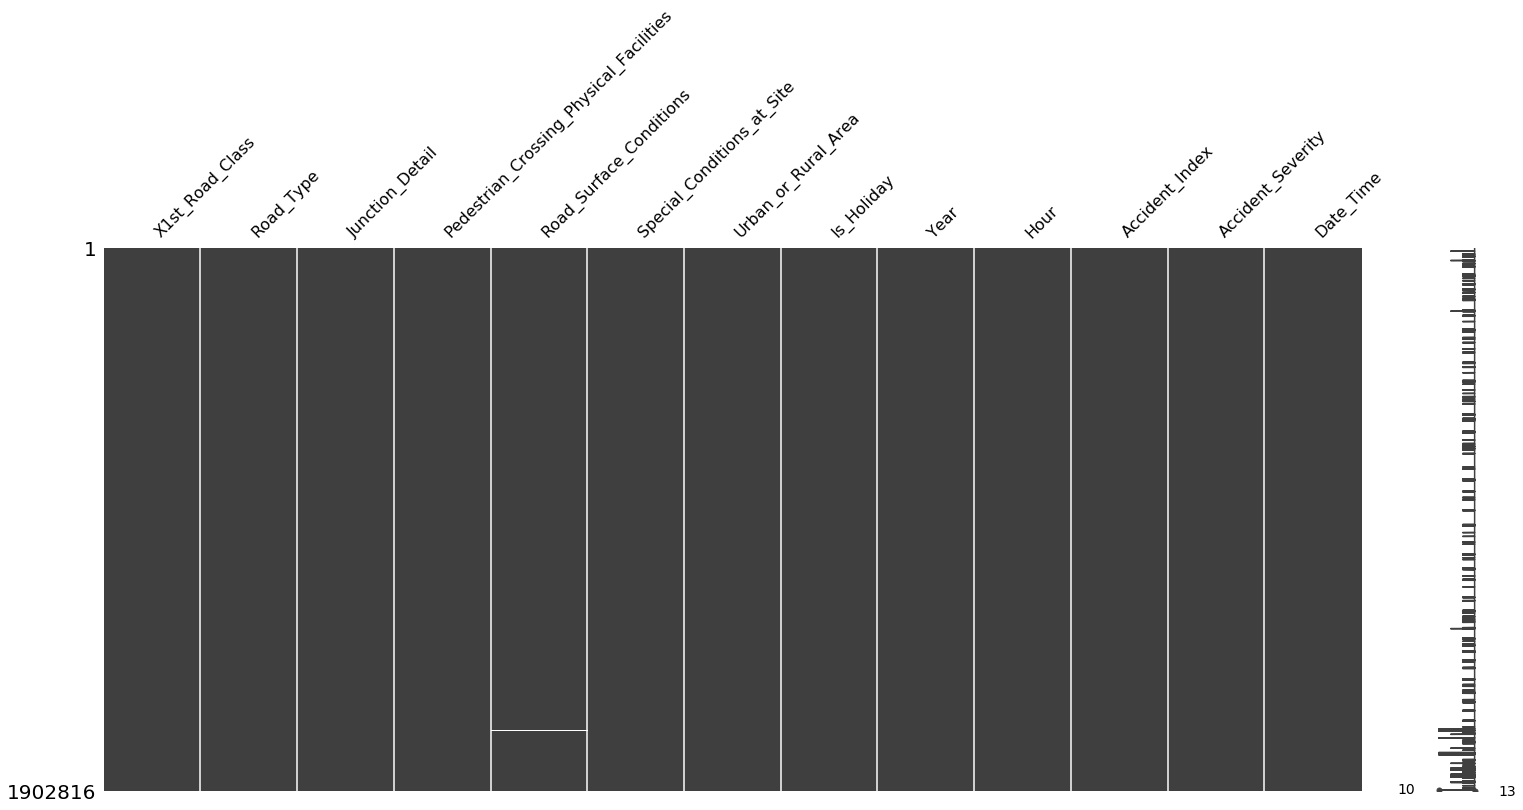

In [28]:
msno.matrix(acc_sel1)

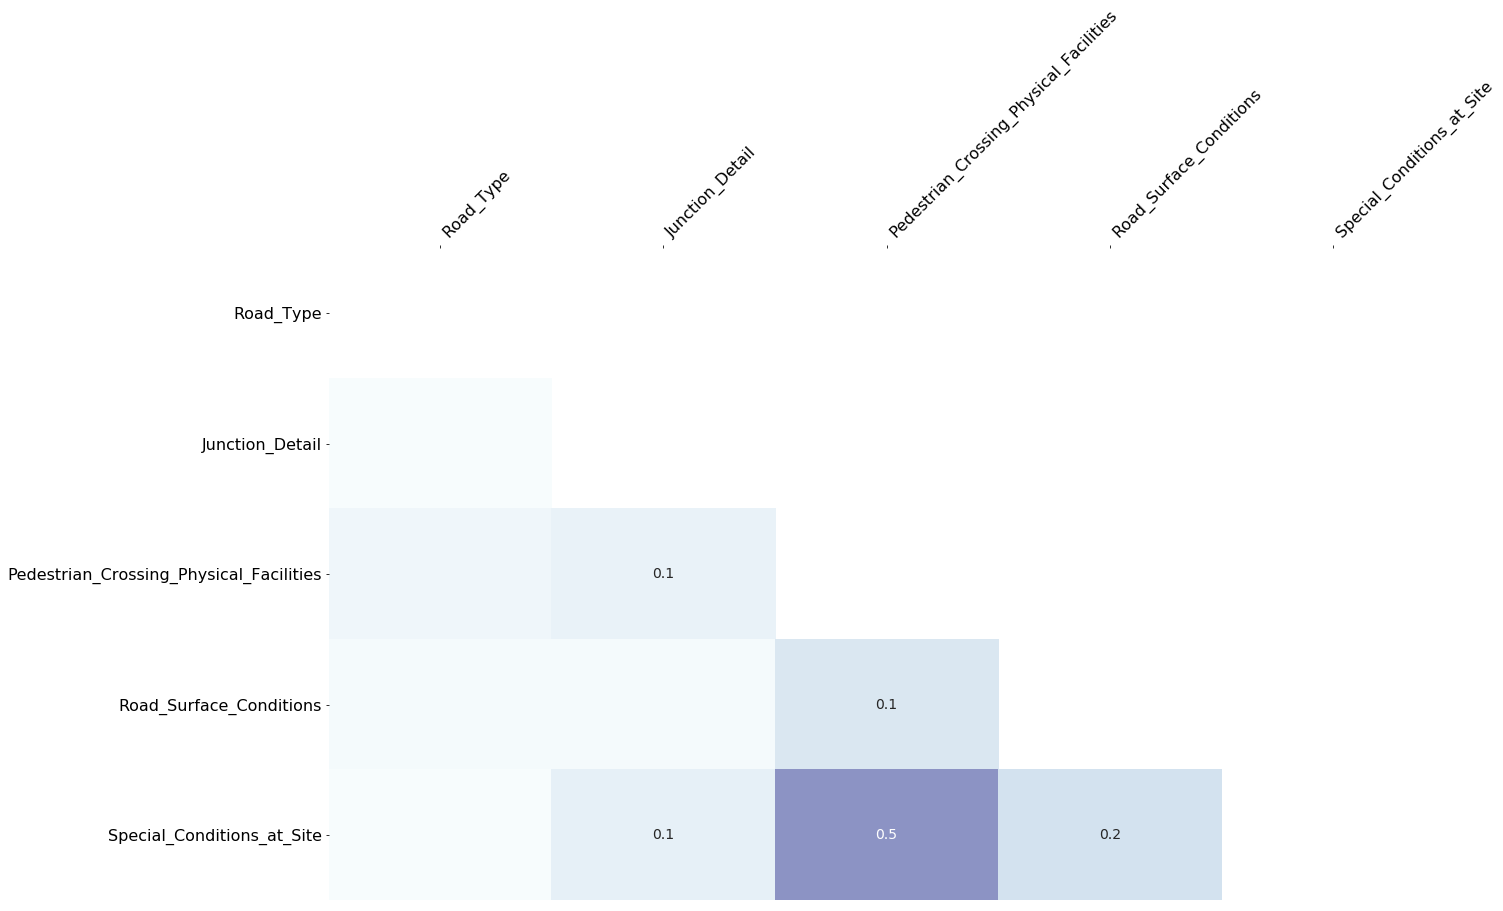

In [29]:
msno.heatmap(acc_sel1, cmap='BuPu')

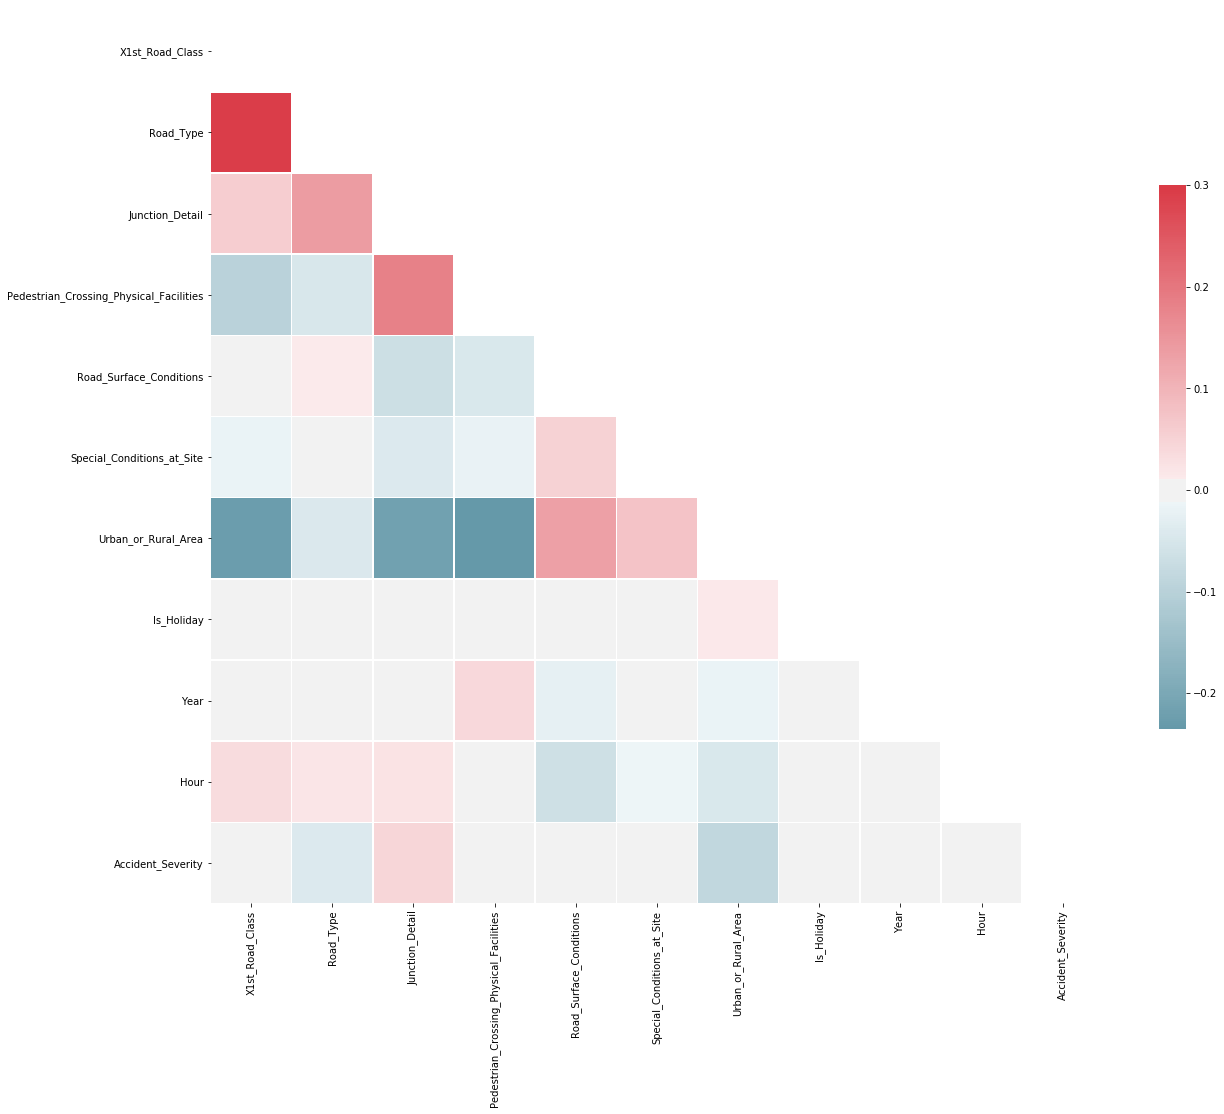

In [30]:
plot_pearsonr(acc_sel1.drop(['Accident_Index', 'Date_Time'], axis=1))

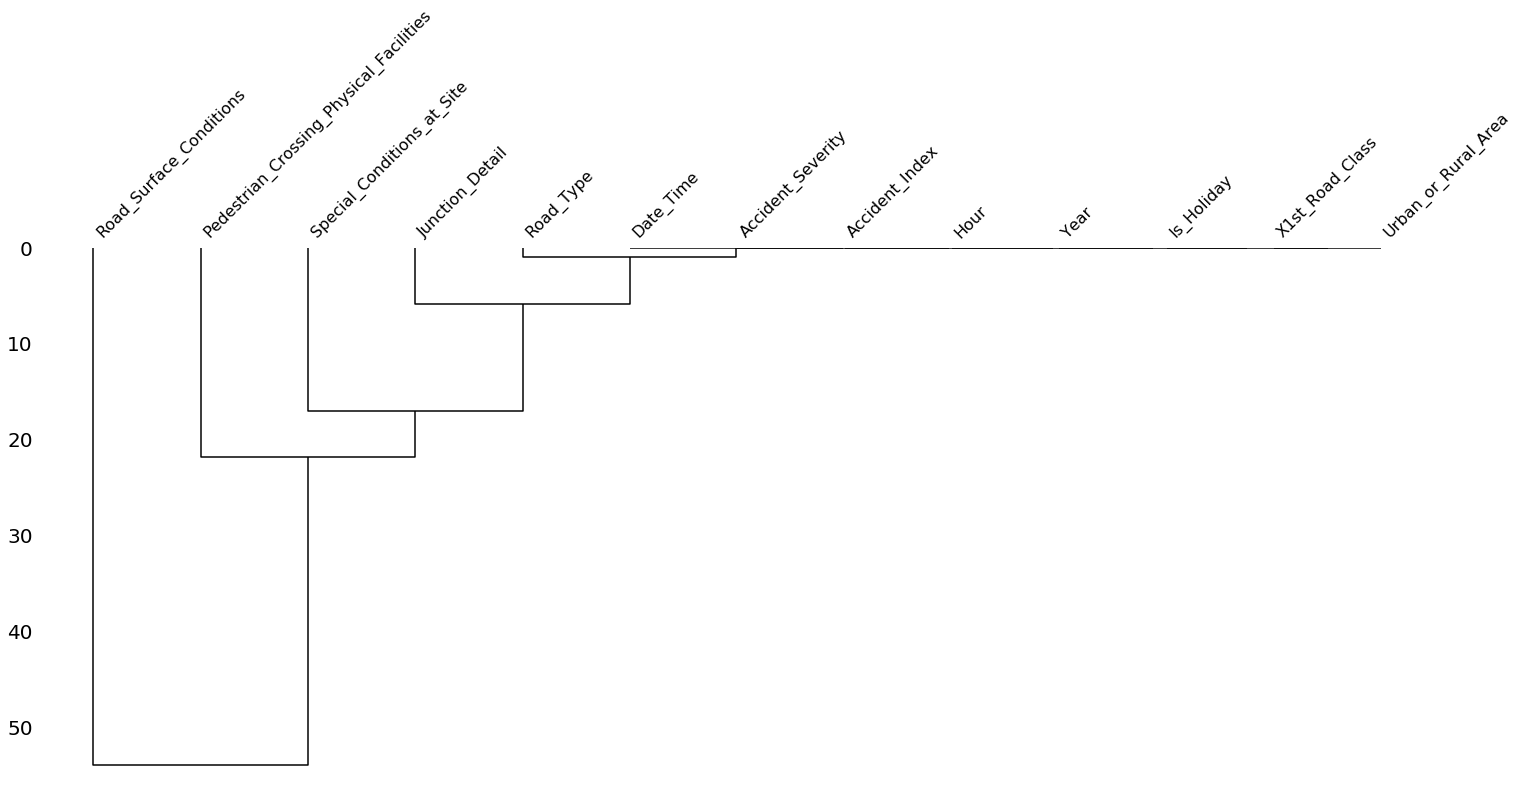

In [31]:
msno.dendrogram(acc_sel1)

In [32]:
# Inspect column wise missing values in detail
[(col, x, round((x/len(acc_sel1)) * 100, 2)) for col, x in zip(acc_sel1.columns, acc_sel1.isnull().sum(axis=0).tolist()) if x > 0]

[('Road_Type', 1, 0.0),
 ('Junction_Detail', 34, 0.0),
 ('Pedestrian_Crossing_Physical_Facilities', 484, 0.03),
 ('Road_Surface_Conditions', 2906, 0.15),
 ('Special_Conditions_at_Site', 289, 0.02)]

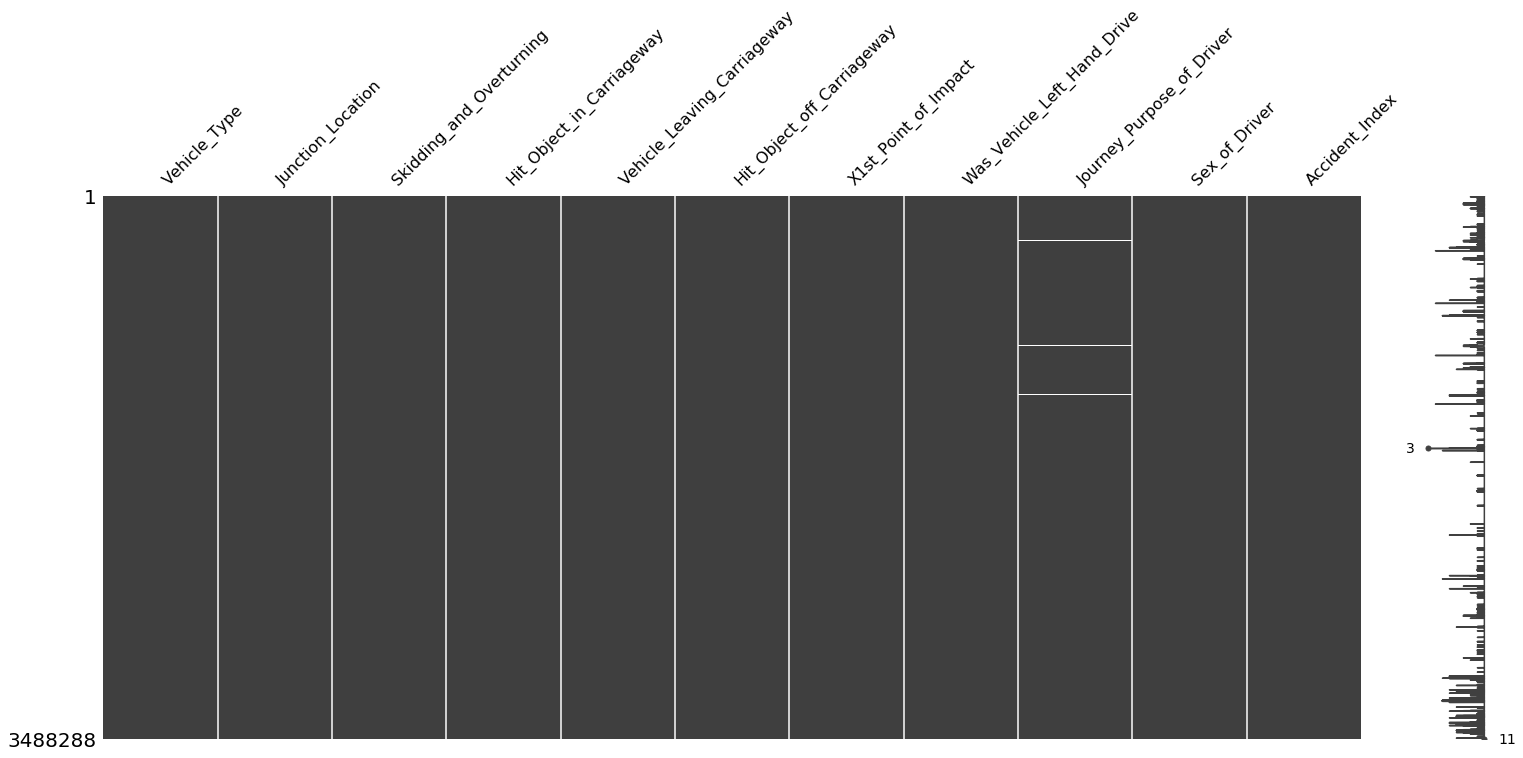

In [33]:
msno.matrix(veh_sel1)

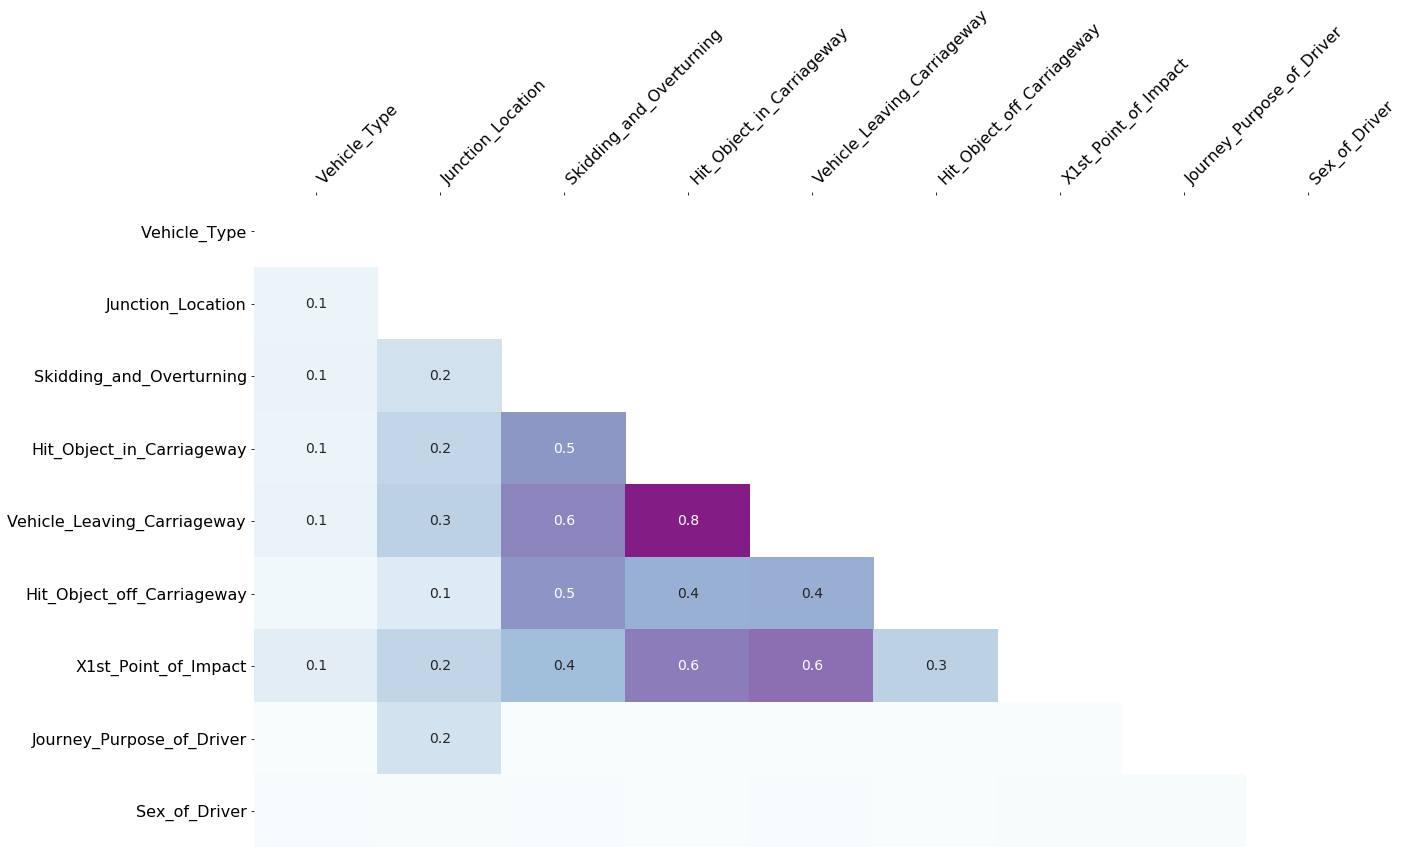

In [34]:
msno.heatmap(veh_sel1, cmap='BuPu')

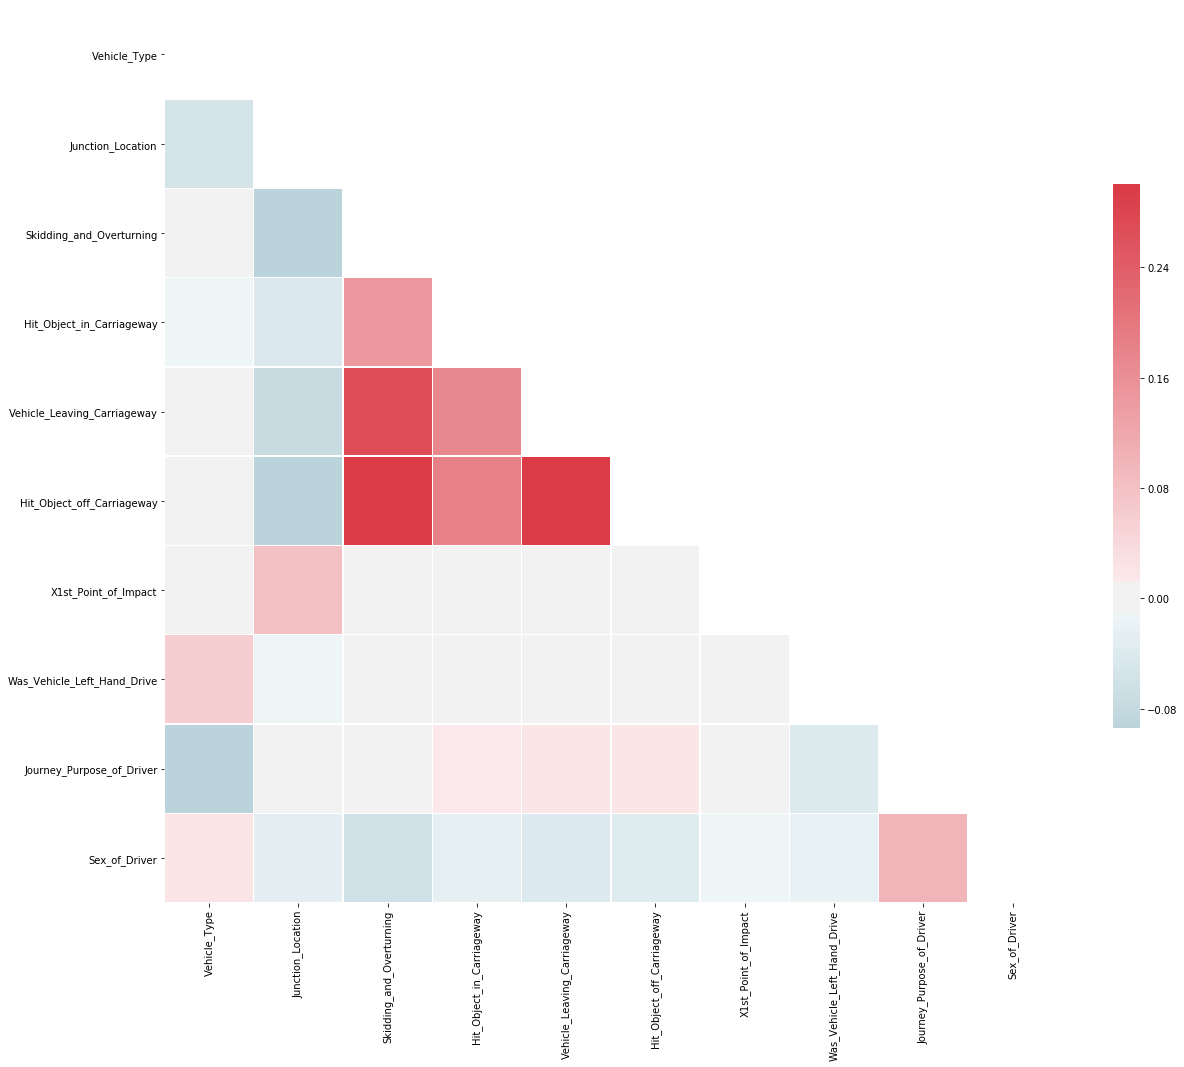

In [35]:
plot_pearsonr(veh_sel1)

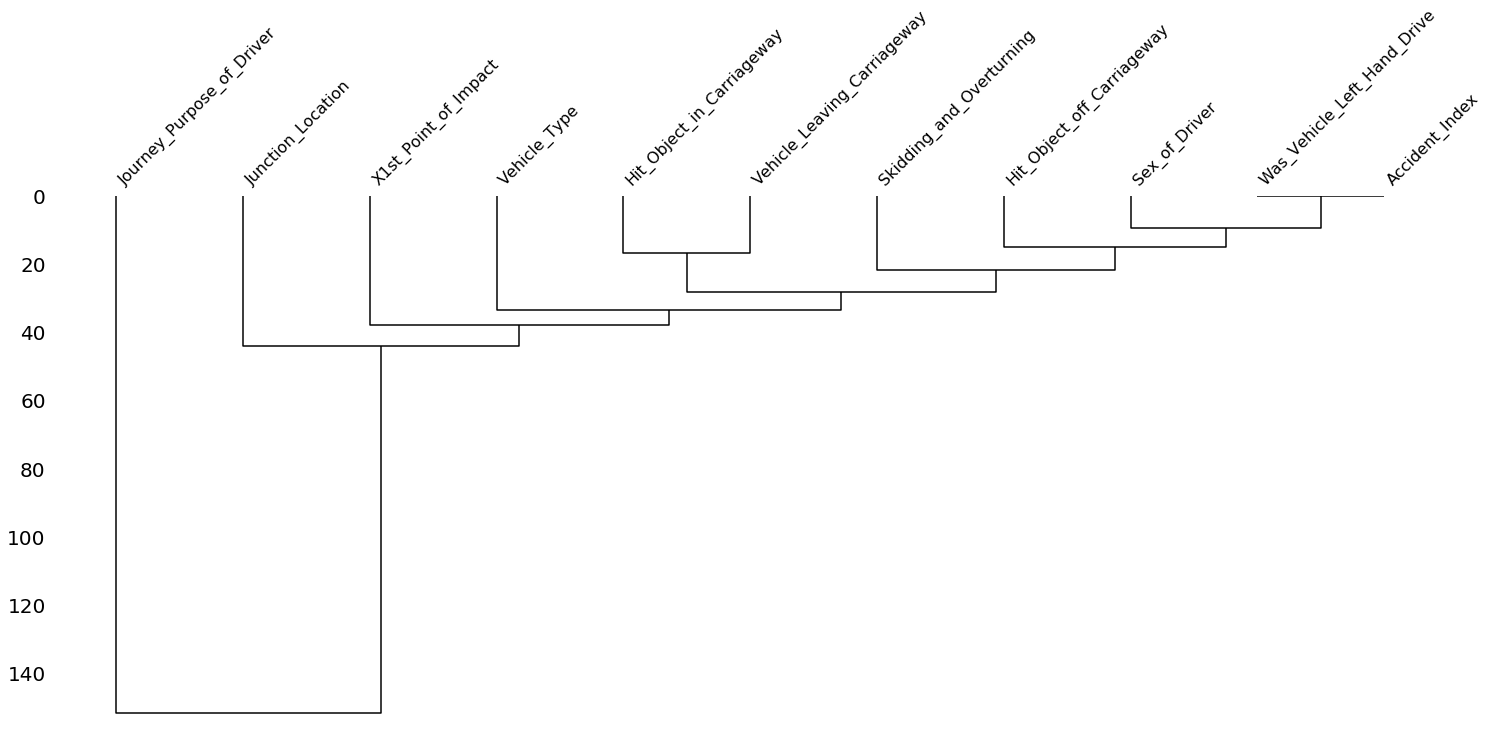

In [36]:
msno.dendrogram(veh_sel1)

In [37]:
# Inspect column wise missing values in detail
[(col, x, round((x/len(veh_sel1)) * 100, 2)) for col, x in zip(veh_sel1.columns, veh_sel1.isnull().sum(axis=0).tolist()) if x > 0]

[('Vehicle_Type', 833, 0.02),
 ('Junction_Location', 1694, 0.05),
 ('Skidding_and_Overturning', 485, 0.01),
 ('Hit_Object_in_Carriageway', 847, 0.02),
 ('Vehicle_Leaving_Carriageway', 867, 0.02),
 ('Hit_Object_off_Carriageway', 201, 0.01),
 ('X1st_Point_of_Impact', 1540, 0.04),
 ('Journey_Purpose_of_Driver', 22621, 0.65),
 ('Sex_of_Driver', 89, 0.0)]

In [38]:
# Inspect row wise missing values
tmp = veh_sel1.isnull().sum(axis=1)
min_tmp = min(tmp)
min_tmp = min_tmp if min_tmp > 0 else 1

for i in range(min_tmp, max(tmp) + 1):
    print(i, ':', len(list(filter(lambda x: x == i, tmp))))

1 : 23346
2 : 1308
3 : 323
4 : 269
5 : 146
6 : 65
7 : 6
8 : 1
